In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from QligFEP.analyze_FEP import FepReader
from pathlib import Path
import json

# JACS

## bace

2025-02-18 14:34:51 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.28_{0.11}^{0.45}$ (Kendall's $\tau$) RMSE = $1.75_{1.45}^{2.02}  \frac{kcal}{mol}$ MUE = $1.42_{1.13}^{1.71}  \frac{kcal}{mol}$


Crashes:  0


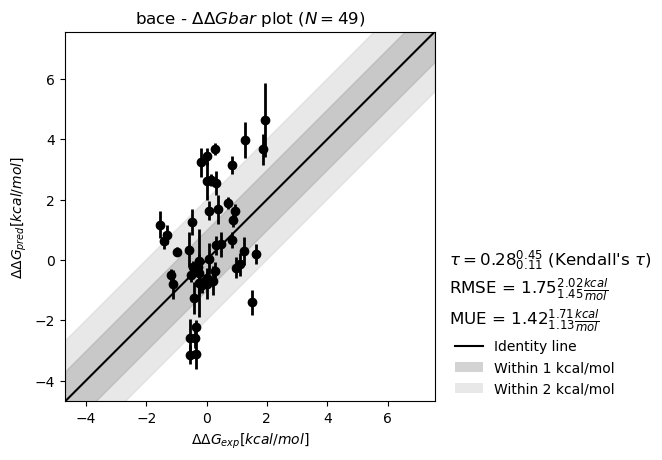

In [3]:
json_results = json.loads(Path("results/bace/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"})
    .query(  # these flipped edges performed worse
        '(~to.isin(["CAT-4j_flip", "CAT-17d_flip"])) & (~_from.isin(["CAT-4j_flip", "CAT-17d_flip"]))'
    )
    .reset_index(drop=True),
    target_name="bace",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

# cdk2

2025-02-18 14:34:53 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.30_{-0.06}^{0.6}$ (Kendall's $\tau$) RMSE = $1.21_{0.88}^{1.53}  \frac{kcal}{mol}$ MUE = $1.02_{0.75}^{1.29}  \frac{kcal}{mol}$


Crashes:  0


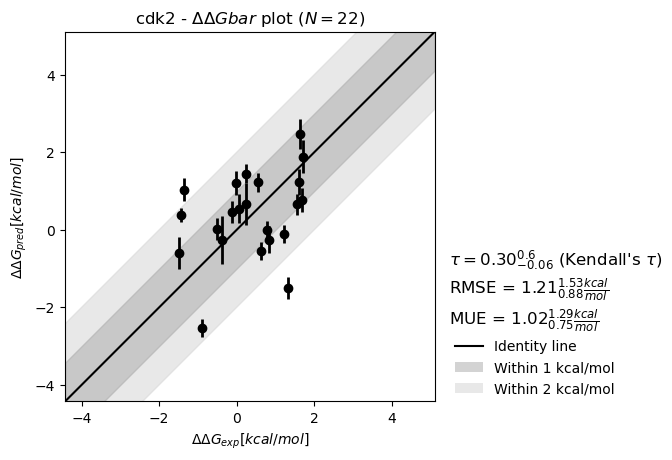

In [4]:
json_results = json.loads(Path("results/cdk2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## jnk1

2025-02-18 14:34:54 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.35_{0.05}^{0.63}$ (Kendall's $\tau$) RMSE = $1.45_{1.07}^{1.83}  \frac{kcal}{mol}$ MUE = $1.17_{0.84}^{1.5}  \frac{kcal}{mol}$


Crashes:  0


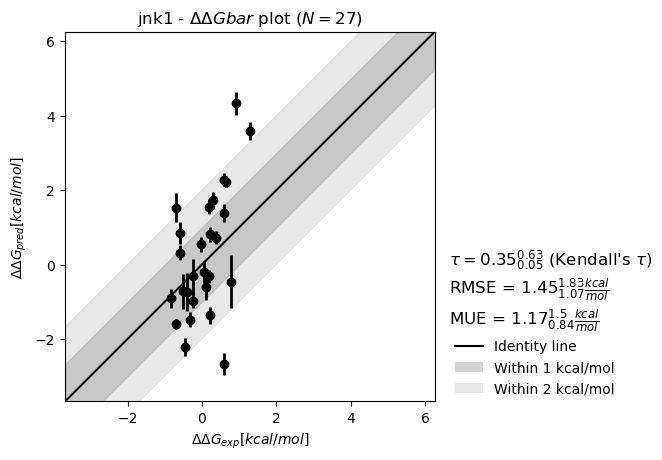

In [5]:
json_results = json.loads(Path("results/jnk1/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="jnk1",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## mcl1

2025-02-18 14:34:57 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.19_{0.03}^{0.36}$ (Kendall's $\tau$) RMSE = $2.04_{1.54}^{2.54}  \frac{kcal}{mol}$ MUE = $1.55_{1.21}^{1.91}  \frac{kcal}{mol}$


Crashes:  0


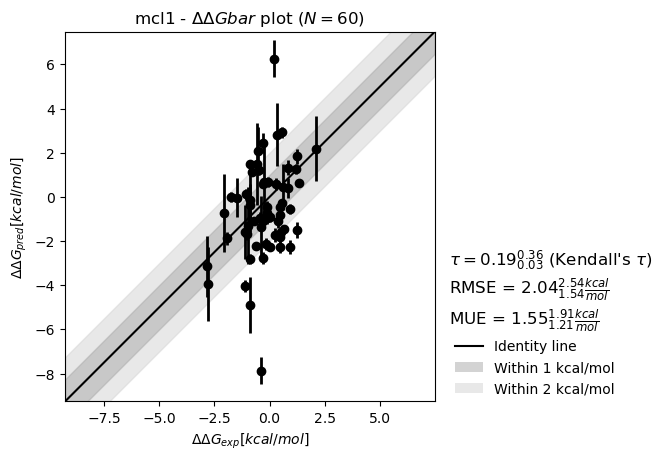

In [6]:
json_results = json.loads(Path("results/mcl1/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="mcl1",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## p38

2025-02-18 14:34:57 | WARNING  | QligFEP.analyze_FEP:create_ddG_plot:478 - Dropping FEPs with nan values: ['FEP_2k_2u']


2025-02-18 14:34:59 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.58_{0.44}^{0.71}$ (Kendall's $\tau$) RMSE = $1.50_{1.25}^{1.76}  \frac{kcal}{mol}$ MUE = $1.22_{1.01}^{1.47}  \frac{kcal}{mol}$


Crashes:  1


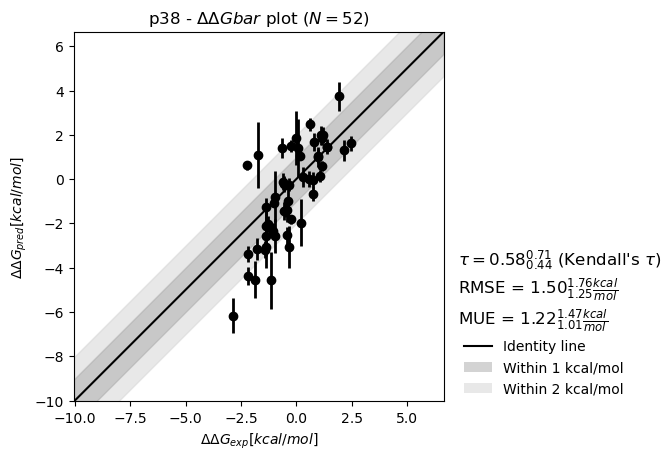

In [7]:
json_results = json.loads(Path("results/p38/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="p38",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## ptp1b

2025-02-18 14:35:01 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.35_{0.08}^{0.6}$ (Kendall's $\tau$) RMSE = $5.28_{4.16}^{6.44}  \frac{kcal}{mol}$ MUE = $4.31_{3.33}^{5.3}  \frac{kcal}{mol}$


Crashes:  0


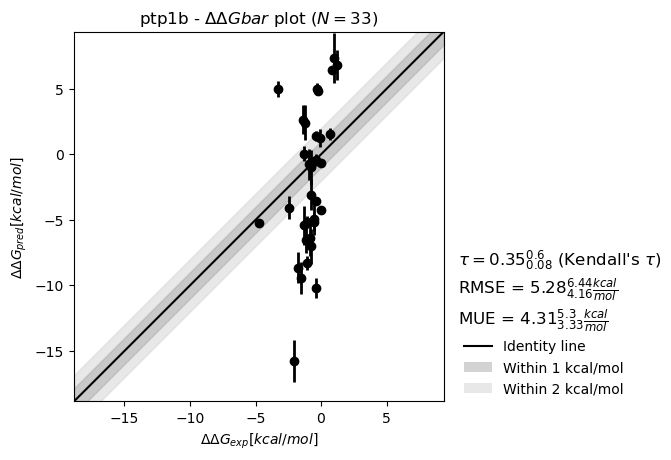

In [8]:
json_results = json.loads(Path("results/ptp1b/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="ptp1b",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## thrombin

2025-02-18 14:35:03 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.43_{-0.05}^{0.85}$ (Kendall's $\tau$) RMSE = $1.17_{0.86}^{1.46}  \frac{kcal}{mol}$ MUE = $1.04_{0.77}^{1.32}  \frac{kcal}{mol}$


Crashes:  0


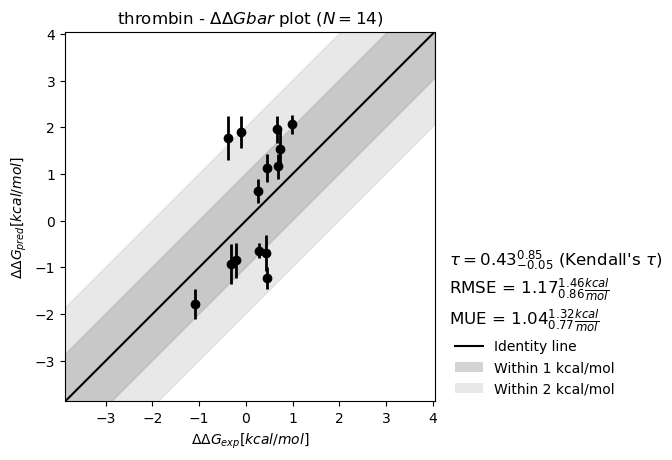

In [9]:
json_results = json.loads(Path("results/thrombin/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="thrombin",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## tyk2

2025-02-18 14:35:05 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.32_{-0.03}^{0.61}$ (Kendall's $\tau$) RMSE = $1.21_{0.87}^{1.54}  \frac{kcal}{mol}$ MUE = $0.97_{0.7}^{1.3}  \frac{kcal}{mol}$


Crashes:  0


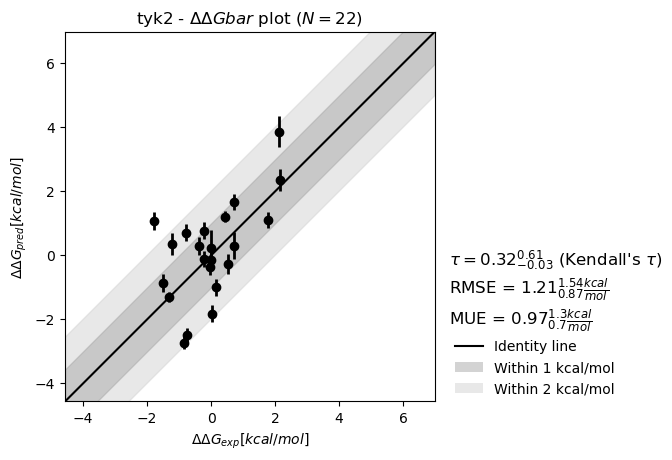

In [10]:
json_results = json.loads(Path("results/tyk2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="tyk2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

# Merck

## cdk8

2025-02-18 14:35:07 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.14_{-0.09}^{0.34}$ (Kendall's $\tau$) RMSE = $3.41_{2.69}^{4.06}  \frac{kcal}{mol}$ MUE = $2.72_{2.15}^{3.37}  \frac{kcal}{mol}$


Crashes:  0


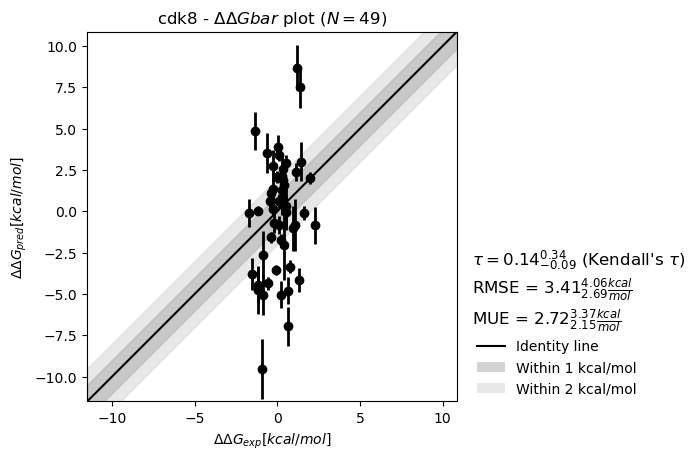

In [11]:
json_results = json.loads(Path("results/cdk8/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk8",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## cmet

2025-02-18 14:35:09 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.44_{0.26}^{0.63}$ (Kendall's $\tau$) RMSE = $2.46_{1.77}^{3.14}  \frac{kcal}{mol}$ MUE = $1.93_{1.43}^{2.46}  \frac{kcal}{mol}$


Crashes:  0


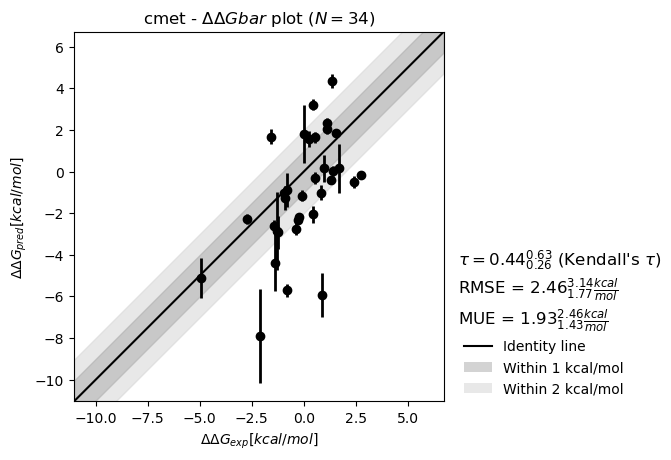

In [12]:
json_results = json.loads(Path("results/cmet/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cmet",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## eg5

2025-02-18 14:35:11 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.31_{0.08}^{0.5}$ (Kendall's $\tau$) RMSE = $1.95_{1.56}^{2.31}  \frac{kcal}{mol}$ MUE = $1.61_{1.28}^{1.93}  \frac{kcal}{mol}$


Crashes:  0


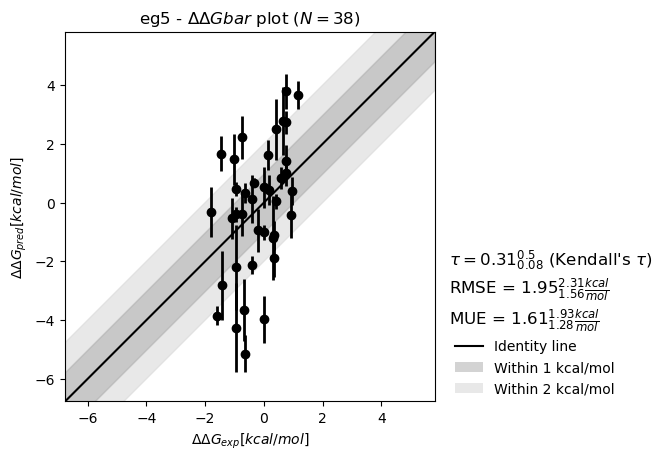

In [13]:
json_results = json.loads(Path("results/eg5/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="eg5",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## hif2a

2025-02-18 14:35:13 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.31_{0.13}^{0.47}$ (Kendall's $\tau$) RMSE = $2.07_{1.73}^{2.42}  \frac{kcal}{mol}$ MUE = $1.71_{1.4}^{2.02}  \frac{kcal}{mol}$


Crashes:  0


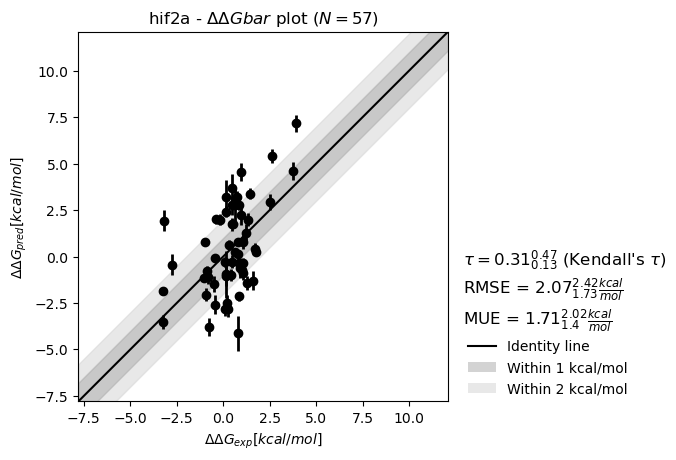

In [14]:
json_results = json.loads(Path("results/hif2a/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="hif2a",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## syk

2025-02-18 14:35:16 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.30_{0.11}^{0.47}$ (Kendall's $\tau$) RMSE = $1.26_{0.99}^{1.52}  \frac{kcal}{mol}$ MUE = $1.01_{0.84}^{1.22}  \frac{kcal}{mol}$


Crashes:  0


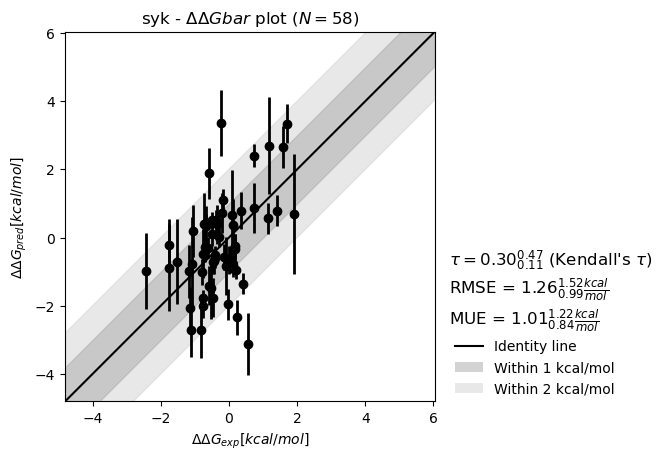

In [15]:
json_results = json.loads(Path("results/syk/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="syk",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

## pfkb3

In [16]:
# TODO

## tnks2

2025-02-18 14:35:18 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:563 - Stats: $\tau = 0.37_{0.1}^{0.6}$ (Kendall's $\tau$) RMSE = $1.24_{0.95}^{1.51}  \frac{kcal}{mol}$ MUE = $1.00_{0.77}^{1.26}  \frac{kcal}{mol}$


Crashes:  0


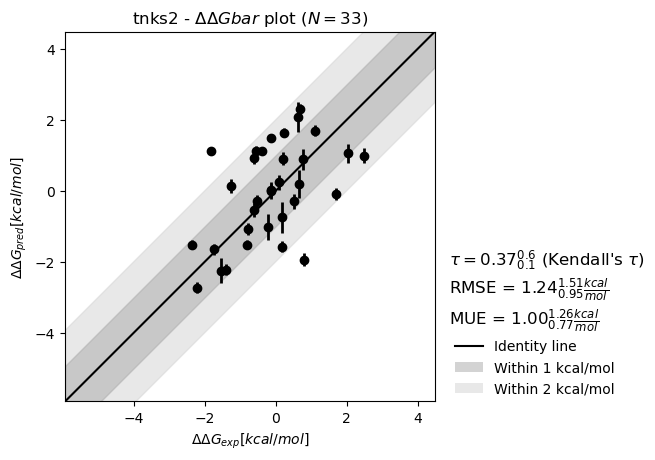

In [17]:
json_results = json.loads(Path("results/tnks2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="tnks2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

# Compare Results

## Imports & Functions

In [18]:
from cinnabar import stats
import pandas as pd
import requests
from io import StringIO

import re
from functools import partial


def clean_latex_strings(text):
    """
    Find LaTeX-like strings with the form $value_{lower}^{upper}$
    and transform them by removing $, {, } symbols and replacing '^' with '_'.
    """
    pattern = r"\$([^\$_]+)_\{([^\}]+)\}\^\{([^\}]+)\}\$"

    def replacement(match):
        value, lower, upper = match.groups()
        return f"{value}_{lower}_{upper}"

    return re.sub(pattern, replacement, text)


def take_value(string, which="sub"):
    values = string.split("_")
    if which == "mean":
        return float(values[0])
    elif which == "sub":
        return float(values[1])
    elif which == "sup":
        return float(values[2])


def get_metrics_df(
    results_df: pd.DataFrame,
    statistics: list,
    targets: list,
    pred_col: str,
    exp_col: str,
):
    results_dict = {}
    for stat in statistics + ["N"]:
        dictionary = {stat: {}}
        for target in targets:
            subset = results_df.query("target == @target")
            if stat == "N":
                dictionary[stat][target] = len(subset)
                continue

            res = stats.bootstrap_statistic(
                subset[pred_col].values, subset[exp_col].values, statistic=stat
            )

            def result_to_latex(res):
                # Round to one decimal
                mle = round(res["mle"], 1)
                low = round(res["low"], 1)
                high = round(res["high"], 1)

                # Generate the LaTeX string
                return f"${mle}_{{{low}}}^{{{high}}}$"

            latex = result_to_latex(res)
            dictionary[stat][target] = latex
        results_dict.update(dictionary)
    metrics_df = pd.DataFrame().from_dict(results_dict)
    return metrics_df

## Load our data

In [19]:
jacs_targs = [
    "bace",
    "cdk2",
    "jnk1",
    "mcl1",
    "p38",
    "ptp1b",
    "thrombin",
    "tyk2",
]
merck_targs = [
    "cdk8",
    "cmet",
    "eg5",
    "hif2a",
    "shp2",
    "syk",
    "pfkfb3",
    "tnks2",
]
targets = jacs_targs + merck_targs

In [20]:
all_data = []

for targ in targets:
    fpath = Path(f"results/{targ}/mapping_ddG.json")
    if not fpath.exists():
        print(f"Skipping {targ}")
        continue

    json_results = json.loads(fpath.read_text())

    df = (
        FepReader.prepare_df(json_results)
        .query("~Q_ddG_avg.isna()")
        .assign(target=targ)
    )

    all_data.append(df)

all_data = pd.concat(all_data)
qligfep_metrics_df = get_metrics_df(
    all_data,
    ["KTAU", "RMSE", "MUE"],
    all_data.target.unique().tolist(),
    "Q_ddG_avg",
    "ddg_value",
)

Skipping pfkfb3


## Fetch other data for comparison

In [21]:
html_root = "https://raw.githubusercontent.com/dfhahn/protein-ligand-benchmark-analysis/refs/heads/master"

res = requests.get(f"{html_root}/03_comparison_experiment/03a_all_edges_all_ffs.csv")
res.raise_for_status()

hahn_results = pd.read_csv(StringIO(res.text), index_col=0).reset_index(
    names=["FEP_ID"]
)

hahn_metrics_df = get_metrics_df(
    hahn_results,
    ["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="DDG_OpenFF-2.0",
    exp_col="DDG_Exp.",
)

### Shevsea

In [22]:
from pathlib import Path

import pandas as pd

rootdir = Path("/zfsdata/data/david/qligfep-benchmark")
openff2results = [
    rootdir / "results/new_results_2/JACS/BACE/openFF2/BACE_ddG.csv",
    rootdir / "results/new_results_2/JACS/CDK2/openFF2/CDK2_ddG.csv",
    rootdir / "results/new_results_2/JACS/JNK1/openFF2/JNK1_ddG.csv",
    rootdir / "results/new_results_2/JACS/MCL1/openFF2/MCL1_ddG.csv",
    rootdir / "results/new_results_2/JACS/p38/openFF2/p38_ddG.csv",
    rootdir / "results/new_results_2/JACS/PTP1B/openFF2/PTP1B_ddG.csv",
    rootdir / "results/new_results_2/JACS/Thrombin/openFF2/Thrombin_ddG.csv",
    rootdir / "results/new_results_2/JACS/Tyk2/openFF2/Tyk2_ddG.csv",
    rootdir / "results/new_results_2/Merck/cdk8/openFF2/cdk8_ddG.csv",
    rootdir / "results/new_results_2/Merck/cmet/openFF2/cmet_ddG.csv",
    rootdir / "results/new_results_2/Merck/eg5/openFF2/eg5_ddG.csv",
    rootdir / "results/new_results_2/Merck/hif2a/openFF2/hif2a_ddG.csv",
    rootdir / "results/new_results_2/Merck/pfkfb3/openFF2/pfkfb3_ddG.csv",
    rootdir / "results/new_results_2/Merck/shp2/openFF2/shp2_ddG.csv",
    rootdir / "results/new_results_2/Merck/syk/openFF2/syk_ddG.csv",
    rootdir / "results/new_results_2/Merck/tnks2/openFF2/tnks2_ddG.csv",
]

opls2015results = [
    rootdir / "results/new_results_2/JACS/BACE/OPLS2015/BACE_ddG.csv",
    rootdir / "results/new_results_2/JACS/CDK2/OPLS2015/CDK2_ddG.csv",
    rootdir / "results/new_results_2/JACS/JNK1/OPLS2015/JNK1_ddG.csv",
    rootdir / "results/new_results_2/JACS/MCL1/OPLS2015/MCL1_ddG.csv",
    rootdir / "results/new_results_2/JACS/p38/OPLS2015/p38_ddG.csv",
    rootdir / "results/new_results_2/JACS/PTP1B/OPLS2015/PTP1B_ddG.csv",
    rootdir / "results/new_results_2/JACS/Thrombin/OPLS2015/Thrombin_ddG.csv",
    rootdir / "results/new_results_2/JACS/Tyk2/OPLS2015/Tyk2_ddG.csv",
    rootdir / "results/new_results_2/Merck/cdk8/OPLS2015/cdk8_ddG.csv",
    rootdir / "results/new_results_2/Merck/cmet/OPLS2015/cmet_ddG.csv",
    rootdir / "results/new_results_2/Merck/eg5/OPLS2015/eg5_ddG.csv",
    rootdir / "results/new_results_2/Merck/hif2a/OPLS2015/hif2a_ddG.csv",
    rootdir / "results/new_results_2/Merck/pfkfb3/OPLS2015/pfkfb3_ddG.csv",
    rootdir / "results/new_results_2/Merck/shp2/OPLS2015/shp2_ddG.csv",
    rootdir / "results/new_results_2/Merck/syk/OPLS2015/syk_ddG.csv",
    rootdir / "results/new_results_2/Merck/tnks2/OPLS2015/tnks2_ddG.csv",
]

openff2_shevsea = pd.concat(
    [
        pd.read_csv(_path).assign(target=_path.stem.split("_")[0])
        for _path in openff2results
    ],
    ignore_index=True,
).assign(target=lambda x: x["target"].str.lower())
opls_shevsea = pd.concat(
    [
        pd.read_csv(_path).assign(target=_path.stem.split("_")[0])
        for _path in opls2015results
    ],
    ignore_index=True,
).assign(target=lambda x: x["target"].str.lower())

shevsea_openff2_metrics_df = get_metrics_df(
    openff2_shevsea,
    statistics=["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="Pred. ddG",
    exp_col="Exp. ddG",
)
# shevsea_openff2_metrics_df.to_excel("shevsea_openff2.xlsx")

shevsea_opls_metrics_df = get_metrics_df(
    opls_shevsea,
    statistics=["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="Pred. ddG",
    exp_col="Exp. ddG",
)
# shevsea_opls_metrics_df.to_excel("shevsea_opls.xlsx")

## Aggregate and plot data

In [23]:
all_results = pd.concat(
    [
        qligfep_metrics_df.assign(data="QligFEPv2 OpenFF 2.2"),
        shevsea_openff2_metrics_df.assign(data="QmapFEP OpenFF 2.0"),
        shevsea_opls_metrics_df.assign(data="QmapFEP OPLS-AA (2015)"),
        hahn_metrics_df.assign(data="Hahn et al. 2023 OpenFF 2.0"),
    ],
    ignore_index=False,
)

details_df = all_results.assign(
    RMSE=lambda x: x["RMSE"].apply(clean_latex_strings),
    MUE=lambda x: x["MUE"].apply(clean_latex_strings),
    KTAU=lambda x: x["KTAU"].apply(clean_latex_strings),
    RMSE_mean=lambda x: x["RMSE"].apply(partial(take_value, which="mean")),
    MUE_mean=lambda x: x["MUE"].apply(partial(take_value, which="mean")),
    KTAU_mean=lambda x: x["KTAU"].apply(partial(take_value, which="mean")),
    RMSE_sub=lambda x: x["RMSE"].apply(partial(take_value, which="sub")),
    MUE_sub=lambda x: x["MUE"].apply(partial(take_value, which="sub")),
    KTAU_sub=lambda x: x["KTAU"].apply(partial(take_value, which="sub")),
    RMSE_sup=lambda x: x["RMSE"].apply(partial(take_value, which="sup")),
    MUE_sup=lambda x: x["MUE"].apply(partial(take_value, which="sup")),
    KTAU_sup=lambda x: x["KTAU"].apply(partial(take_value, which="sup")),
)

/tmp/ipykernel_67297/2692584271.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/tmp/ipykernel_67297/2692584271.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


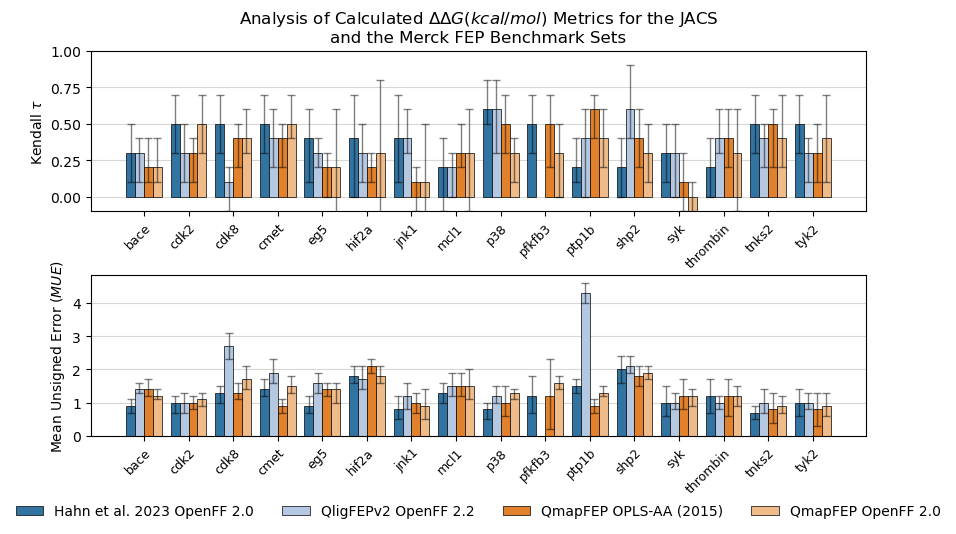

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

palette = "tab20"
fig, axs = plt.subplots(nrows=2, figsize=(10, 5))

toplot_data = (
    details_df.reset_index(names=["target"])
    .assign(target_data=lambda x: x["target"] + " " + x["data"])
    .rename(columns={"data": "ForceField"})
    .sort_values(["target", "ForceField"])
)

metrics = ["KTAU", "MUE"]

for ax, metric in zip(axs.flatten(), metrics):
    error_df = toplot_data[[f"{metric}_sub", f"{metric}_sup"]]
    lower_error = toplot_data[f"{metric}_mean"] - error_df[f"{metric}_sub"]
    upper_error = error_df[f"{metric}_sup"] - toplot_data[f"{metric}_mean"]
    error_values = np.array([lower_error, upper_error])

    barplot = sns.barplot(
        toplot_data,
        hue="ForceField",
        x="target",
        y=f"{metric}_mean",
        ax=ax,
        palette=palette,
        edgecolor="black",
        linewidth=0.5,
    )
    for idx, bar in enumerate(barplot.patches):
        x_bar = bar.get_x() + bar.get_width() / 2
        y_bar = bar.get_height()

        try:
            yerr = [[error_values[0, idx]], [error_values[1, idx]]]
        except IndexError:
            break

        # Add error bars with the correct shape
        ax.errorbar(
            x_bar,
            y_bar,
            yerr=np.array(yerr).reshape(2, 1),
            color="black",
            fmt="none",
            elinewidth=1,
            capsize=3,
            alpha=0.5,
        )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor",
        fontsize=9,
    )
    if metric == "KTAU":
        ax.set_title(
            "Analysis of Calculated $ΔΔG (kcal/mol)$ Metrics for the JACS\nand the Merck FEP Benchmark Sets",
        )
        # ax.legend(bbox_to_anchor=(1.02, -0.45), loc="lower left", borderaxespad=0, frameon=False)
        ax.set_ylabel(r"Kendall $\tau$")
        ax.legend().set_visible(False)
        ax.set_ylim(-0.1, 1)
    elif metric == "MUE":
        # ax.legend().set_visible(False)
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.35),
            frameon=False,
            shadow=True,
            ncol=5,
        )
        ax.set_ylabel("Mean Unsigned Error $(MUE)$")
    ax.set_xlabel("")
    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)
# fig.tight_layout()
plt.subplots_adjust(hspace=0.4)
fig.savefig("all_metrics.png", bbox_inches="tight", dpi=600)